## Personalizovani PageRank za sistem preporuka

PageRank je algoritam za određivanje verovatnoća posećivanja čvorova grafa pri slučajnim šetnjama. Nastao je kao algoritam za rangiranje internet stranica i samim tim je pogodan u primeni kod sistema preporuka. Prikazana je njegova upotreba za predviđanje korisničkih ocena filmova na *MovieLens 100K* (https://grouplens.org/datasets/movielens/100k/) skupu podataka.

Personalizovani PageRank algoritam pretpostavlja da je u slučajnoj šetnji verovatnoća prelaska na svaki susedan čvor jednaka. Verovatnoće prelaska predstavljene su matricom $P$. Takođe, pretpostavlja postojanje određene verovatnoće teleportacije određene konstantom $1 - \alpha$ i vekotorom presonalizacije $s$. Vektor stacionarne raspodele verovatnoća (rangova) čvorova može se izraziti na sledeći način: $$ p = (1 - \alpha) s + \alpha P p $$

$p$ se određuje kao sopstveni vektor matrice $(1 - \alpha) s e^T + \alpha P$ metodom stepenovanja.

Jednostavna modifikacija algoritma je pretpostavka da su slučajne šetnje lenje. Matrica verovatnoća prelaska je pri ovoj modifikaciji $Z = \frac{I + P}{2}$. Može se pokazati da su ove dve formulacije algoritma ekvivalentne do na promenu konstante $\alpha$.

Primenjujemo algoritam aproksimacije ove varijante personalizovanog PageRank algoritma. Ideja je početi od vektora personalizacije i "gurati" verovatnoću na susedne čvorove dokle god ne dobijemo željenu preciznost aproksimacije. Algoritam je složenosti $O(\frac{m \log \epsilon}{1-\alpha})$.

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from surprise import SVD
from surprise import Dataset
from surprise import model_selection
from surprise import accuracy
from surprise import Reader
from surprise.prediction_algorithms.predictions import Prediction
from time import time

In [2]:
class PageRankRecommender():
    
    '''Rating prediction algorithm using PageRank
    
    A personalized PageRank is used to calculate the stationary distribution
    of all movie-rating pairs for a given user. The predictions for a particular
    movie are then taken to be the expected value over the movie-rating nodes.
    
    Args:
        alpha: The parameter used in the PageRank algorithm. Probability of 
            teleportation is 1 - alpha.
        eps: Tolerance used to check convergence when using the PageRank
            approximation algorithm. Default is ``1e-6``.
        algo: If ``"sharp"`` the PageRank approximation algorithm is used.
            If ``"pagerank"`` the default networkx implementation is used.
            Default is ``"sharp"``.
    '''
    
    # Algoritam za predviđanje ocena pomoću PageRank-a
    #
    # Presonalizovani PageRank se koristi za izračunavanje stacionarne
    # respodele svih parova film-ocena za datog korisnika. Predviđene
    # ocene za konkretan film se onda računaju kao očekivana vrednost
    # po film-ocena čvorovima.
    #
    # Args:
    #     alpha: Parametar korišćen u PageRank algoritmu. Verovatnoća
    #         teleportacije je 1 - alpha.
    #     eps: Tolerancija korišćena pri ispitivanju konvergencije kada
    #         se koristi algoritam za aproksimaciju PageRank-a.
    #         Podrazumevano je 1e-6.
    #     algo: Ako je "sharp" koristi se algoritam aproksimacije.
    #         Ako je "pagerank" koristi se običan PageRank.
    #         Podrazumevano je "sharp".
    
    def __init__(self, alpha, eps = 1e-6, algo = 'sharp'):
        
        self.alpha = alpha
        self.beta = 2 * (1 - alpha) / alpha
        self.eps = eps
        self.algo = algo
        
        self.predicted = {}
        self.possible_ratings = []
    
    def __build_graph(self, data):
        
        # Builds a graph from the (user, movie, rating) tuples.
        # Each user is associated with the vertex ('u', user_id).
        # Each movie-rating pair is associated with the vertex
        # ('m', movie_id, rating). An edge is then added connecting
        # the user node and the movie-rating node.
        
        # Formira graf na osnovu (user, movie, rating) torki.
        # Svakom korisniku je dodeljen čvor ('u', user_id).
        # Svakom paru film-ocena je dodeljen čvor
        # ('m', movie_id, rating). Grana se zatim dodaje tako da
        # povezuje čvor korisnika i čvor para film-ocena.
        
        G = nx.Graph()
        
        for user, movie, rating in data.all_ratings():
            user_node = ('u', int(data.to_raw_uid(user)))
            movie_node = ('m', int(data.to_raw_iid(movie)), rating)
            G.add_edge(user_node, movie_node)
        
        return G
    
    def fit(self, data, val_data = None):
        
        # Calculates predictions for all user-movie pairs in the
        # dataset. For each user, it does so by first calculating
        # the personalized PageRank rankings of all vertices of the graph
        # with the personalization vector set to t[user] = 1. Afterwards,
        # the user rating for each movie is calculated as a weighted
        # average of all ratings with weights being the personalized
        # rankings of the nodes associated with the movie-rating pair.
        # If validation data is given, output the RMSE at every step.
        
        # Računa predviđanja za sve parove korisnik-film u skupu
        # podataka. Za svakog korisnika se prvo računaju personalizovani
        # PageRank rangovi svih čvorova grafa pri čemu je vektor
        # personalizacije postavljen na t[korisnik] = 1. Nakon toga,
        # korisnička ocena svakog filma se računa kao težinski
        # prosek svih ocena, gde su težine zapravo personalizovani
        # rangovi čvorova dodeljenih parovima film-ocena.
        # Ukoliko su dati podaci za validaciju, prikazuje RMSE u
        # svakom koraku.
        
        logging = (val_data is not None)
        
        self.possible_ratings = sorted(set([rating for (_, _, rating) in data.all_ratings()]))
        self.mean_rating = data.global_mean
        
        G = self.__build_graph(data)
        
        node_to_idx = dict(zip(G.nodes, range(len(G))))
        users = [node[1] for node in G.nodes if node[0] == 'u']
        movies = list(set([node[1] for node in G.nodes if node[0] == 'm']))
        
        if logging:
            val_map = {(int(user), int(movie)) : float(rating) for (user, movie, rating) in val_data}
            MSE_sum = 0
            MSE_cnt = 0
        
        users_bar = tqdm(users)
        for user in users_bar:
            t = {node : 0 for node in G.nodes}
            t[('u', user)] = 1

            if self.algo == 'pagerank':
                p = nx.pagerank(G, personalization = t, alpha = self.alpha)
            else:
                p = self.__sharp_pagerank(G, node_to_idx, t = t)

            for movie in movies:
                
                weighted_sum = sum([p[('m', movie, rating)] for rating in self.possible_ratings if ('m', movie, rating) in p])
                weighted_rating = sum([rating * p[('m', movie, rating)] for rating in self.possible_ratings if ('m', movie, rating) in p])
                        
                if weighted_sum == 0:
                    self.predicted[user, movie] = self.mean_rating
                else:
                    self.predicted[user, movie] = weighted_rating / weighted_sum
                
                if logging:
                    if (user, movie) in val_map:
                        MSE_sum += (val_map[user, movie] - self.predicted[user, movie]) ** 2
                        MSE_cnt += 1

            if logging and MSE_cnt > 0:
                users_bar.set_description(f'Alpha = {self.alpha :.2f}  RMSE = {np.sqrt(MSE_sum / MSE_cnt) :.5f} | Progress ')
    
    def test(self, data):
        
        # Outputs the calculated predictions for each user-movie pair.
        # If a prediction could not be made the mean value of all
        # ratings from the training data is used.
        
        # Vraća izračunata predviđanja za svaki par korisnik-film.
        # Ukoliko predviđanje nije bilo moguće izračunati koristi
        # se srednja vrednost svih ocena iz trening skupa.
        
        predictions = []
        
        for user, movie, rating in data:
            user = int(user)
            movie = int(movie)
            if (user, movie) in self.predicted:
                estimated_rating = self.predicted[user, movie]
                details = {'was_impossible' : False}
            else:
                estimated_rating = self.mean_rating
                details = {'was_impossible' : True}
            predictions.append(Prediction(uid = user,
                                          iid = movie,
                                          r_ui = rating,
                                          est = estimated_rating,
                                          details = details))

        return predictions
    
    def __pr_push(self, G, node, node_to_idx, p, r, prob, eps):
        
        # Implements the Push subroutine of the sharp PageRank
        # approximation algorithm.
        
        # Implementira Push proceduru algoritma aproksimacije
        # PageRank-a.
        
        u = node_to_idx[node]

        upd = r[u] / ((2.0 + self.beta) * G.degree[node])
        for node_v in G.neighbors(node):
            v = node_to_idx[node_v]
            r[v] = r[v] + upd
            if r[v] > eps * G.degree[node_v]:
                prob.add(node_v)

        p[u] = p[u] + self.beta / (2.0 + self.beta) * r[u]
        r[u] = r[u] / (2.0 + self.beta)

        if r[u] <= eps * G.degree[node]:
            prob.remove(node)

        return p, r, prob

    def __pr_approximate(self, G, node_to_idx, s, eps):
        
        # Implements the ApproximatePR subroutine of the sharp
        # PageRank approximation algorithm.
        
        # Implementira ApproximatePR proceduru algoritma
        # aproksimacije PageRank-a.
        
        p = np.zeros(len(G))
        r = s

        prob = set([])
        for node in G.nodes:
            if r[node_to_idx[node]] > eps * G.degree[node]:
                prob.add(node)

        while prob:
            node = next(iter(prob))
            p, r, prob = self.__pr_push(G, node, node_to_idx, p, r, prob, eps)

        return p, r

    def __sharp_pagerank(self, G, node_to_idx, t = None):
        
        # Implements the main loop of the sharp PageRank
        # approximation algorithm.
        
        # Implementira glavnu petlju algoritma aproksimacije
        # PageRank-a.
        
        n = len(G)

        if t is None:
            s = np.ones(n) / n
        else:
            s = np.zeros(n)
            for node, tw in t.items():
                s[node_to_idx[node]] = tw

        c_eps = 1.0
        p = np.zeros(n)
        r = s

        while c_eps > self.eps:
            c_eps /= 2
            p_d, r_d = self.__pr_approximate(G, node_to_idx, r, c_eps)
            p += p_d
            r = r_d

        ret = {node : p[node_to_idx[node]] for node in G.nodes}
        return ret

Koristimo skup podataka *MovieLens 100K* pomoću funkcije za preuzimanje ugrađenih skupova podataka modula *Surprise*. Skup se sastoji od niza uređenih trojki tipa (user_id, movie_id, rating). Podatke delimo na skup za treniranje, validaciju i testiranje u odnosima 70:15:15. Ovo radimo kako bismo validacijom odabrali pogodnu vrednost za metaparametar $\alpha$ PageRank algoritma.

Jedna napomena je da se tip podataka skupa za treniranje razlikuje od tipa podataka skupa za validaciju i testiranje, pa kada se konačno vrši testiranje potrebno je ponovo uraditi razlaganje početnog skupa podataka, ovog puta na skup za treniranje i testiranje u odnosu 85:15. Vodimo računa da koristimo istu vrednost za *random_state* parametar.

In [3]:
data = Dataset.load_builtin('ml-100k')
train_data, test_val_data = model_selection.train_test_split(data, test_size = 0.3, random_state = 0)
val_data = test_val_data[:len(test_val_data) // 2]

In [4]:
def VSearch(algo, train_data, val_data):
    
    alphas = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]
    eps = 1e-6
    
    models = {}
    best_alpha = None
    for alpha in alphas:
        model = PageRankRecommender(alpha = alpha, eps = eps, algo = algo)
        model.fit(train_data, val_data = val_data)
        model_predictions = model.test(val_data)
        models[alpha] = accuracy.rmse(model_predictions)
        if best_alpha is None or models[best_alpha] > models[alpha]:
            best_alpha = alpha
            
    return best_alpha

alpha_sharp = VSearch('sharp', train_data, val_data)
alpha_vanilla = VSearch('pagerank', train_data, val_data)


RMSE: 1.1549



RMSE: 1.1742



RMSE: 1.2210



RMSE: 1.3250



RMSE: 1.1620



RMSE: 0.9943



RMSE: 0.9894



RMSE: 0.9940



RMSE: 0.9987



RMSE: 1.0002



RMSE: 1.0005



RMSE: 1.0017



RMSE: 1.0032



RMSE: 1.0047



RMSE: 1.0063



RMSE: 1.0087


Poredimo rezultate tri algoritma: aproksimacija PageRank-a, običan PageRank i SVD ugrađen u modul *Surprise*. Parametar $\alpha$ za prva dva algoritma je dobijen validacijom. Parametri za SVD su podrazumevani. To podešavanje je korišćeno na istom skupu podataka pri testiranju rađenom u okviru *Surprise* projekta (http://surpriselib.com/).

In [5]:
train_data, test_data = model_selection.train_test_split(data, test_size = 0.15, random_state = 0)

times = []

pr_sharp_time_start = time()
pr_sharp = PageRankRecommender(alpha = alpha_sharp, eps = 1e-6)
pr_sharp.fit(train_data)
pr_sharp_time_finish = time()
times.append((pr_sharp_time_finish - pr_sharp_time_start) / 60)

pr_vanilla_time_start = time()
pr_vanilla = PageRankRecommender(alpha = alpha_vanilla, algo = 'pagerank')
pr_vanilla.fit(train_data)
pr_vanilla_time_finish = time()
times.append((pr_vanilla_time_finish - pr_vanilla_time_start) / 60)

svd_time_start = time()
svd = SVD()
svd.fit(train_data)
svd_time_finish = time()
times.append((svd_time_finish - svd_time_start) / 60)

In [6]:
rmse = []
mae = []

print('Sharp PageRank approximation')
predictions = pr_sharp.test(test_data)
rmse.append(accuracy.rmse(predictions))
mae.append(accuracy.mae(predictions))
print()

print('PageRank')
predictions = pr_vanilla.test(test_data)
rmse.append(accuracy.rmse(predictions))
mae.append(accuracy.mae(predictions))
print()

print('SVD')
predictions = svd.test(test_data)
rmse.append(accuracy.rmse(predictions))
mae.append(accuracy.mae(predictions))

Sharp PageRank approximation
RMSE: 0.9799
MAE:  0.7779

PageRank
RMSE: 0.9941
MAE:  0.7931

SVD
RMSE: 0.9404
MAE:  0.7417


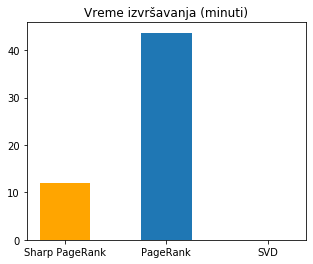

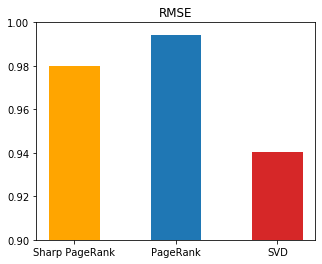

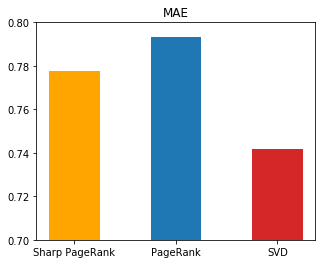

In [10]:
names = ['Sharp PageRank', 'PageRank', 'SVD']
colors = ['orange', 'C0', 'C3']

plt.figure(figsize = (5, 4))
plt.title('Vreme izvršavanja (minuti)')
plt.bar(names, times, color = colors, width = 0.5)
plt.show()

plt.figure(figsize = (5, 4))
plt.title('RMSE')
plt.bar(names, rmse, color = colors, width = 0.5)
plt.ylim(0.9, 1.0)
plt.show()

plt.figure(figsize = (5, 4))
plt.title('MAE')
plt.bar(names, mae, color = colors, width = 0.5)
plt.ylim(0.7, 0.8)
plt.show()